In [2]:
#IMPORT USED PACKAGES AND SET SEED
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
import pickle
import random
from datetime import datetime
import pandas as pd
import csv
import pbs
import os
import sys
import itertools
import json
from multiprocessing import Pool
from spellchecker import SpellChecker
from IPython.display import display
random.seed(123)

In [3]:
time = datetime.strftime(datetime.now(), "%Y_%m_%d_%H_%M_%S")

# Preprocessing

#### Remove duplicated tweets

In [16]:
def drop_duplicate(input_filename):
    with open("Datasets/"+input_filename, encoding="utf-8") as f :
        tweets = f.read().splitlines()
        df_tweets = pd.DataFrame(tweets,columns=['Tweets'])
        df_tweets.drop_duplicates(inplace=True)
    with open('Processed_data/no_dupl_' + input_filename, "w+", encoding = "UTF-8") as f:
        for tweet in df_tweets["Tweets"]:
            f.write("%s\n" % tweet)

In [17]:
for file in ['train_pos.txt','train_neg.txt','train_neg_full.txt','train_pos_full.txt']:
    drop_duplicate(file)

In [18]:
# drop duplicates test
with open("Datasets/test_data.txt", encoding="utf-8") as f :
    test = f.read().splitlines()
    tweets = []
    ids = []
    for line in test:
        id, tweet = line.split(',',1)
        tweets.append(tweet)
        ids.append(id)
    df_test = pd.DataFrame(tweets,ids,columns=['Tweets'])
    df_test.drop_duplicates(inplace=True)
    
with open('Processed_data/no_dupl_test_data.txt', "w+", encoding = "UTF-8") as f:
    for tweet in df_test["Tweets"]:
        f.write("%s\n" % tweet)

#### Concatenate all text files (pos, neg and test) to create a dataset used as reference for twitter language

In [19]:
with open("Processed_data/twitter_language.txt", "w+", encoding = "utf-8") as f:
    for path in ['Processed_data/no_dupl_train_pos.txt','Processed_data/no_dupl_train_neg.txt', 'Processed_data/no_dupl_test_data.txt']:
        with open(path,encoding="utf-8") as file:
            f.write(file.read())

In [20]:
with open("Processed_data/twitter_language_full.txt", "w+", encoding = "utf-8") as f:
    for path in ['Processed_data/no_dupl_train_pos_full.txt','Processed_data/no_dupl_train_neg_full.txt', 'Processed_data/no_dupl_test_data.txt']:
        with open(path,encoding="utf-8") as file:
            f.write(file.read())

###  Spell correction

In [21]:
## Create a frequency dictionnary of words occuring at least *threshold* times in the dataset, 
## that will be used as a reference for spell checking

output_filename = 'Processed_data/vocab_freq.txt'
vocab_successful = os.system("build_vocab.sh Processed_data/twitter_language.txt " + output_filename)

if (vocab_successful != 0):
    sys.exit("Building vocabulary failed.")

In [22]:
## Create a frequency dictionnary of words occuring at least *threshold* times in the dataset, 
## that will be used as a reference for spell checking

output_filename = 'Processed_data/vocab_freq_full.txt'
vocab_successful = os.system("build_vocab.sh Processed_data/twitter_language_full.txt " + output_filename)

if (vocab_successful != 0):
    sys.exit("Building vocabulary failed.")

In [23]:
def build_dictionnary(input_vocab, threshold):
    full_vocab = pd.read_csv(input_vocab+".txt", sep = "\s+", header=None, engine='python')
    cut_vocab = full_vocab[full_vocab[0] >= threshold]
    cut_vocab.columns = ["number occ","word"]
    cut_vocab.set_index("word",inplace=True)
    with open(input_vocab + '.json', 'w') as f:
        json.dump(cut_vocab["number occ"].to_dict(), f) 

build_dictionnary("Processed_data/vocab_freq", threshold=5) #TODO try other threshold
build_dictionnary("Processed_data/vocab_freq_full", threshold=5) #TODO try other threshold

In [54]:
## Spell correction functions
def correct(tweet, dict_corr):
    list_words = tweet.split()
    for i, word in enumerate(list_words):
        if word in dict_corr :
            list_words[i] = dict_corr[word]
    corr_tweet = ' '.join(list_words)
    return (corr_tweet) 

def spell_correction(data):
    spell = SpellChecker(distance=1) # TODO if possible, try distance=2
    spell.word_frequency.load_dictionary('Processed_data/vocab_freq_full.json') #'Processed_data/vocab_freq_full.json')
    dict_corr = {}
    for tweet in data["Tweets"]:
        list_words = tweet.split()
        for i, word in enumerate(list_words):
            if word not in dict_corr :
                if word in spell.unknown([word]):
                    dict_corr[word] = spell.correction(word)
    data["Tweets"] = data["Tweets"].apply(lambda x : correct(x, dict_corr))
    return data, dict_corr

In [55]:
#Define the used datasets here
positive_dataset = 'Processed_data/no_dupl_train_pos_full.txt' #'Processed_data/no_dupl_train_pos_full.txt'
negative_dataset = 'Processed_data/no_dupl_train_neg_full.txt' #'Processed_data/no_dupl_train_neg_full.txt'

def load_in_pd(data_path):
    with open(data_path, encoding="utf-8") as f :
        x = f.read().splitlines()
        x = pd.DataFrame(x,columns=['Tweets'])
    return (x)

positive_pd = load_in_pd(positive_dataset)
negative_pd = load_in_pd(negative_dataset)

In [56]:
%%time
### APPLYING spell correction to pos and neg

positive_preprocessed, dict_corr1 = spell_correction(positive_pd)  
with open('Processed_data/' + 'positive_spell_full.txt', "w+", encoding = "UTF-8") as f: #positive_spell_full.txt', "w+", encoding = "UTF-8") as f:
    for tweet in positive_preprocessed["Tweets"]:
        f.write("%s\n" % tweet)
del positive_preprocessed
print("done positive")

negative_preprocessed, dict_corr2 = spell_correction(negative_pd)
with open('Processed_data/' + 'negative_spell_full.txt', "w+", encoding = "UTF-8") as f: #negative_spell_full.txt', "w+", encoding = "UTF-8") as f:
    for tweet in negative_preprocessed["Tweets"]:
        f.write("%s\n" % tweet)
del negative_preprocessed

done positive
Wall time: 12min 44s


In [57]:
### APPLYING spell correction to test

test_dataset = "Datasets/test_data.txt"

def load_in_pd_test(data_path):
    with open(data_path, encoding="utf-8") as f :
        test = f.read().splitlines()
        tweets = []
        ids = []
        for line in test:
            id, tweet = line.split(',',1)
            tweets.append(tweet)
            ids.append(id)
        test = pd.DataFrame(tweets,ids,columns=['Tweets'])
    return test

test_pd = load_in_pd_test(test_dataset)
test_spell, dict_corr_test = spell_correction(test_pd) 

with open("Processed_data/test_spell.txt", "w+", encoding="utf-8") as f:
    for index, row in test_spell.iterrows():
        f.write(index + "," + row["Tweets"] + "\n")

.

.

.

.

.

In [58]:
# gather input for word embeddings
with open("Processed_data/input_WE_full.txt", "w+", encoding = "utf-8") as f:
    with open("Processed_data/test_spell.txt",encoding="utf-8") as test:
        test = test.readlines()
        for line in test:
            id, tweet = line.split(',',1)
            f.write("%s" % tweet)
    
    for path in ['Processed_data/positive_spell_full.txt','Processed_data/negative_spell_full.txt']:
        with open(path,encoding="utf-8") as file:
            f.write(file.read())

In [59]:
output_filename = 'Processed_data/vocab_freq_after_spell_full.txt' #'Processed_data/vocab_freq_after_spell_full.txt'
vocab_successful = os.system("build_vocab.sh Processed_data/input_WE_full.txt " + output_filename)

if (vocab_successful != 0):
    sys.exit("Building vocabulary failed.")


In [60]:
full_vocab_spell = pd.read_csv('Processed_data/vocab_freq_after_spell_full.txt', sep = "\s+", header=None, engine='python')
full_vocab_spell.columns = ["number occ","word"]
full_vocab_spell.set_index("word",inplace=True)
    #with open(input_vocab + '.json', 'w') as f:
     #   json.dump(cut_vocab["number occ"].to_dict(), f) 

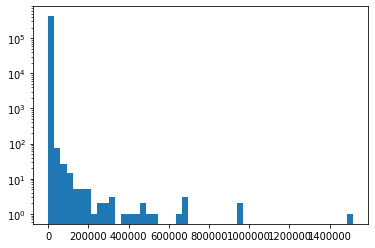

In [61]:
plt.yscale("log")
plt.hist(full_vocab_spell["number occ"],bins=50)
plt.show()

In [65]:
full_vocab_spell[full_vocab_spell["number occ"]>50000].sort_values(by="number occ")

,number occ
word,
*,50136
as,50779
think,51981
he,52740
2,53311
<3,54287
can't,54573
going,54748
thanks,54976


In [4]:
##APPLY build_vocab.sh AND CUT THE VOCABULARY USING THE CHOSEN THRESHOLD

#Choose the desired cutting parameter here (Tokens with >= cut_threshold occurrences are kept)
cut_threshold = 5

output_filename = 'Processed_data/vocab_full' + time + '.txt'
vocab_successful = os.system("build_vocab.sh Processed_data/input_WE_full.txt " + output_filename)

if (vocab_successful != 0):
    sys.exit("Building vocabulary failed.")
    
def cut_and_save_vocab(file_in, file_out):
    full_vocab = pd.read_csv(file_in, sep = "(\s+)", header=None, engine = 'python')
    cutted_vocab = full_vocab[full_vocab[0] >= cut_threshold][2]
    with open(file_out, 'w+') as f:
        f.write(cutted_vocab.to_string(header = False, index = False))
    
cut_and_save_vocab('Processed_data/vocab_full' + time + '.txt', 'Processed_data/vocab_cut_full' + time + '.txt')
    

In [5]:
##DUMP THE BUILT VOCABULARY TO A PICKLE FILE
vocab = dict()
with open('Processed_data/vocab_cut_full' + time + '.txt') as f:
    for idx, line in enumerate(f):
        vocab[line.strip()] = idx

with open('Processed_data/vocab_full' + time + '.pkl', 'wb') as f:
    pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)

In [10]:
%%time
##CREATE A CO-OCCURRENCE MATRIX
def create_cooc(vocab_file, negative_file, positive_file, output_file):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    vocab_size = len(vocab)
    data, row, col = [], [], []
    counter = 1
    for fn in [negative_file, positive_file]:
        with open(fn,encoding="utf8") as f:
            for line in f:
                tokens = [vocab.get(t, -1) for t in line.strip().split()]
                tokens = [t for t in tokens if t >= 0]
                for i,t1 in enumerate(tokens):
                    for t2 in tokens[i+1:]:
                        if t1==t2 :
                            data.append(1/2)
                        else :
                            data.append(1)
                        row.append(min(t1,t2))
                        col.append(max(t1,t2))

                if counter % 10000 == 0:
                    print(counter)
                counter += 1

                if counter % 300000 == 0:
                    print(len(data))
                    cooc = coo_matrix((data, (row, col)))
                    print("summing duplicates (this can take a while)")
                    cooc.sum_duplicates()
                    data=list(cooc.data)
                    row=list(cooc.row)
                    col=list(cooc.col)
                    print(len(data))

    print(len(data))
    cooc = coo_matrix((data, (row, col)))
    print("summing duplicates (this can take a while)")
    cooc.sum_duplicates()
    
    data=list(cooc.data)
    row=list(cooc.row)
    col=list(cooc.col)
    final_row = row+col
    final_col = col+row
    data = data+data
    cooc = coo_matrix((data, (final_row, final_col)))
    
    with open(output_file, 'wb') as f:
        pickle.dump(cooc, f, pickle.HIGHEST_PROTOCOL)
        
#Used datasets should be defined on the second code block
create_cooc('Processed_data/vocab_full' + time + '.pkl', 'Processed_data/negative_spell_full.txt', 'Processed_data/positive_spell_full.txt',
            'Processed_data/cooc_pickle_full' + time + '.pkl')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
47322680
summing duplicates (this can take a while)
7324683
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
54631410
summing duplicates (this can take a while)
11762272
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
59009757
summing duplicates (this can take a while)
15359122
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
116000

In [16]:
%%time
##CREATE A CO-OCCURRENCE MATRIX with context defined with threshold distance
def context(lst,index,threshold):
    return(lst[index+1 : min(index+threshold,len(lst)-1)])

def create_cooc_dist(vocab_file, negative_file, positive_file, output_file, threshold):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    vocab_size = len(vocab)
    data, row, col = [], [], []
    counter = 1
    for fn in [negative_file, positive_file]:
        with open(fn,encoding="utf8") as f:
            for line in f:
                tokens = [vocab.get(t, -1) for t in line.strip().split()]
                #tokens = [t for t in tokens if t >= 0]
                for i,t1 in enumerate(tokens):
                    if t1 >= 0:
                        for t2 in context(tokens,i,threshold):
                            if t2 >= 0:
                                if t1==t2 :
                                    data.append(1/2)
                                else :
                                    data.append(1)
                                row.append(min(t1,t2))
                                col.append(max(t1,t2))

                if counter % 10000 == 0:
                    print(counter)
                counter += 1

                if counter % 3000000 == 0:
                    print(len(data))
                    cooc = coo_matrix((data, (row, col)))
                    print("summing duplicates (this can take a while)")
                    cooc.sum_duplicates()
                    data=list(cooc.data)
                    row=list(cooc.row)
                    col=list(cooc.col)
                    print(len(data))

    print(len(data))
    cooc = coo_matrix((data, (row, col)))
    print("summing duplicates (this can take a while)")
    cooc.sum_duplicates()
    
    data=list(cooc.data)
    row=list(cooc.row)
    col=list(cooc.col)
    final_row = row+col
    final_col = col+row
    data = data+data
    cooc = coo_matrix((data, (final_row, final_col)))
    
    with open(output_file, 'wb') as f:
        pickle.dump(cooc, f, pickle.HIGHEST_PROTOCOL)
        
#Used datasets should be defined on the second code block
create_cooc_dist('Processed_data/vocab_full' + time + '.pkl', 'Processed_data/negative_spell_full.txt', 'Processed_data/positive_spell_full.txt',
            'Processed_data/cooc_dist_pickle_full' + time + '.pkl',3)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

In [ ]:
## APPLY glove.py
random.seed(123)
def glove(cooc_pickle, output_file):
    print("loading cooccurrence matrix")
    with open(cooc_pickle, 'rb') as f:
        cooc = pickle.load(f)
    print("{} nonzero entries".format(cooc.nnz))

    nmax = 100
    print("using nmax =", nmax, ", cooc.max() =", cooc.max())

    print("initializing embeddings")
    embedding_dim = 20
    xs = np.random.normal(size=(cooc.shape[0], embedding_dim))
    ys = np.random.normal(size=(cooc.shape[1], embedding_dim))

    eta = 0.001
    alpha = 3 / 4

    epochs = 10

    for epoch in range(epochs):
        print("epoch {}".format(epoch))
        for ix, jy, n in zip(cooc.row, cooc.col, cooc.data):
            logn = np.log(n)
            fn = min(1.0, (n / nmax) ** alpha)
            x, y = xs[ix, :], ys[jy, :]
            scale = 2 * eta * fn * (logn - np.dot(x, y))
            xs[ix, :] += scale * y
            ys[jy, :] += scale * x
    np.save(output_file, xs)

glove('Processed_data/cooc_pickle' + time + '.pkl', 'Processed_data/embeddings' + time + '.npy')

In [ ]:
##### PREPARE DATA FOR TRAINING A CLASSIFIER

def load_train_data(data_path):
    """Loads data and returns ids (event ids) and X (feature vector)"""
    f = open(data_path, encoding="utf-8")
    x = f.read().splitlines()
    x = pd.DataFrame(x, columns=['Tweets'])
    return x

def representation(tweet, we, vocab):
    acc = np.array(0)
    n_ignored_word = 0
    for word in tweet.split():
        if word not in vocab.keys():
            n_ignored_word += 1
        else:
            try:
                acc = np.add(acc,we[vocab[word]])
            except: 
                #print("problem with " + word) #last word from vocab is missing in cooc
                n_ignored_word += 1
    n = len(tweet.split()) - n_ignored_word
    acc = acc / n
    return(acc)


def create_train_data(positive_path, negative_path, vocab, we):
    pos = load_train_data(positive_path)
    neg = load_train_data(negative_path)
    pos["y"] = 1
    neg["y"] = -1

    print('pos...')
    
    pos.reset_index(drop = True, inplace = True)
    pos["w"] = pos["Tweets"].apply(lambda x: representation(x, we, vocab))
    pos.drop("Tweets", axis=1, inplace = True)

    col = ["w" + str(k) for k in range(np.shape(we)[1])]
    pos[col] = pos["w"].apply(pd.Series)
    pos.drop("w",axis=1,inplace=True)
    
    #remove the tweets which do not have any words used more than 5 times in the training dataset
    pos.dropna(inplace=True) 
    
    
    with open('Processed_data/pos' + time + '.pkl', 'wb') as k:
        pickle.dump(pos, k, pickle.HIGHEST_PROTOCOL)
    del pos
    print('pos done')
    
    print('neg')
    neg.reset_index(drop = True, inplace = True)
    neg["w"] = neg["Tweets"].apply(lambda x: representation(x, we, vocab))
    neg.drop("Tweets", axis=1, inplace = True)

    col = ["w" + str(k) for k in range(np.shape(we)[1])]
    neg[col] = neg["w"].apply(pd.Series)
    neg.drop("w",axis=1,inplace=True)
    
    #remove the tweets which do not have any words used more than 5 times in the training dataset
    neg.dropna(inplace=True)
    
    print('neg done')
    
    with open('Processed_data/pos' + time + '.pkl', 'rb') as j:
        pos = pickle.load(j)
    
    print('lets try to concatenate')
    train = pd.concat([pos, neg])
    print('tadaaaa')
    return train

with open('Processed_data/vocab_' + time + '.pkl', 'rb') as f:
    vocab = pickle.load(f)
we = np.load('Processed_data/embeddings' + time + '.npy')
#The names of the datasets are defined in the second code block
train = create_train_data(positive_dataset, negative_dataset, vocab, we)

In [ ]:
##TRAIN A CLASSIFIER

from sklearn.linear_model import SGDClassifier
X = train.drop("y", axis=1)
y = train["y"]
random.seed(123)
clf = SGDClassifier()
clf.fit(X, y) 

In [ ]:
##### LOAD THE TEST DATA, USE THE MODEL TO PREDICT THE SENTIMENTS AND SAVE THE PREDICTIONS

def load_and_prepare_test_data(data_path,vocab, we):
    """Loads data and returns ids (event ids) and X (feature vector)"""
    f = open(data_path, encoding='utf-8')
    test = f.read().splitlines()
    tweets = []
    ids = []
    for line in test:
        id, tweet = line.split(',',1)
        tweets.append(tweet)
        ids.append(id)
    test = pd.DataFrame(tweets,ids,columns=['Tweets'])
    test["w"] = test["Tweets"].apply(lambda x: representation(x, we, vocab))
    col = ["w" + str(k) for k in range(np.shape(we)[1])]
    test[col] = test["w"].apply(pd.Series)
    test.drop("w", axis=1, inplace = True)
    test.drop("Tweets", axis=1, inplace = True)
    
    drops = test[test.isnull().any(axis=1)].index
    #for the tweets which do not have any words in the cutted vocabulary, predict 1
    test.fillna(1, inplace=True)
    
    return test,drops

test, drops = load_and_prepare_test_data('Datasets/test_data.txt', vocab, we)
test["Prediction"] = clf.predict(test)
#test["Id"] = test.index
test["Prediction"].to_csv("Submissions/submission" + time + ".csv", header= True, index_label = "Id")